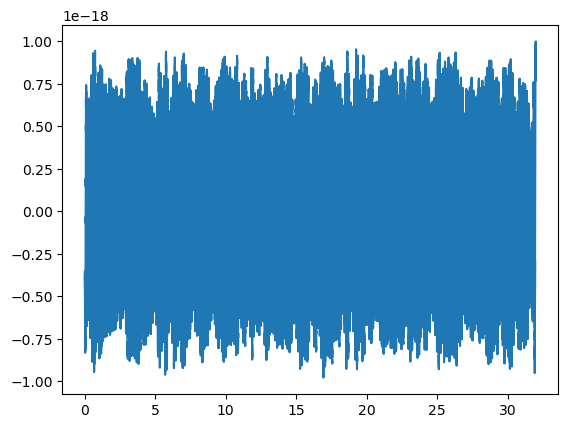

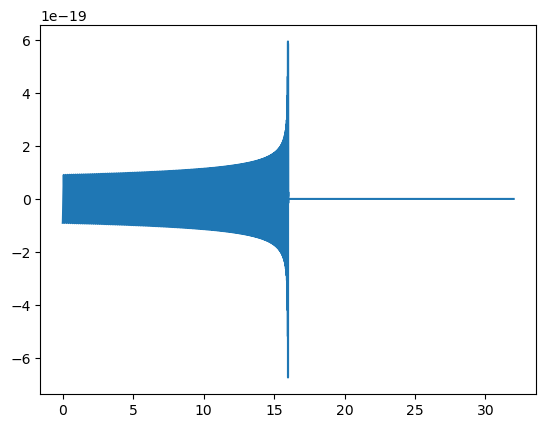

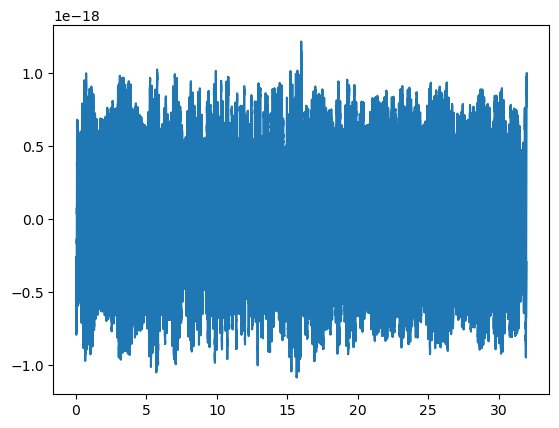

In [812]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.fft import fft, ifft
from scipy.signal import welch, periodogram
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter


# leggo la seconda colonna del file (noise + signal)
strain_data = np.loadtxt('dati_H1_32s_progetto_3.txt')[:, 1]
# leggo il file dove c'è il template del signal
strain_template = np.loadtxt('GW170104_4_template.txt')
# genero il noise
strain_noise = strain_data - strain_template

# Settiamo le variabili T ed N, dove T è il tempo di acquisizione in secondi(32 dato dalla specifica) 
# e N è il numero di righe dei dati della specifica (131072)
T = 32
N = len(strain_data)

# calcolo la frequenza di acquisizione (4096Hz)
fs = N / T
# calcolo l'intervallo temporale di acquisizione (0.000244140625s)
dt = 1./fs

# creo l'array del tempo, cioé un array che parte da 0, e crea gli elementi 
# successivi aggiungendo il valore "dt" ai precedenti fino a raggiungere il valore di T
# quindi stiamo creando l'asse x per il grafico dove ogni punto è il momento in cui è 
# stato campionato il segnale. Avremo quindi 131072 punti.
time = np.arange(0, T, dt)

# Questa è la risoluzione in frequenza
df = 1/T

# imposto il limite inferiore e il limite superiore per visualizzare il plot dei dati
x_min = int(0*fs)
x_max = int(32*fs)

# Facciamo il plot dei dati
plt.plot(time[x_min:x_max], strain_data[x_min:x_max])
plt.show()

# Plottiamo il segnale del template
plt.plot(time[x_min:x_max], strain_template[x_min:x_max])
plt.show()

# Plot del noise
plt.plot(time[x_min:x_max], strain_noise[x_min:x_max])
plt.show()

Notiamo che abbiamo un segnale che è come quello di un'onda gravitazionale, il segnale parte dall'inizio e finisce nel momento in cui c'è la coalescenza dei due buchi neri. Questo momento è circa a poco più della metà dei 32 secondi.

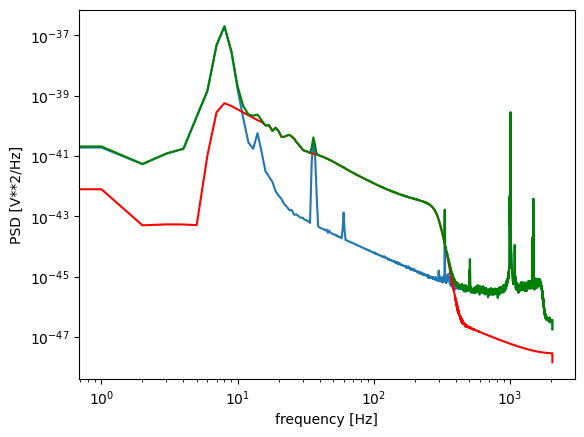

In [813]:
# Calcoliamo il PSD dei dati, del rumore e del segnale, con welch per fare la media ed evitare troppa varianza
f, Pxx = welch(strain_data, fs=4096, window='hamming', nperseg=4096, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
f, Pxx_template = welch(strain_template, fs=4096, window='hamming', nperseg=4096, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
f, Pxx_noise = welch(strain_noise, fs=4096, window='hamming', nperseg=4096, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
plt.semilogy(f, Pxx)
plt.semilogy(f, Pxx_template, "red")
plt.semilogy(f, Pxx_noise, "green")
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [814]:
# Mi calcolo Sn

# Faccio il welch del noise two sided
f_welch, Pxx_noise_welch = welch(strain_noise, fs=4096, window='hamming', nperseg=4096, noverlap=None, nfft=None, detrend='constant', return_onesided=False, scaling='density', axis=-1, average='mean')
#faccio il periodogram dei dati two sided
f2sided, Pxx_data = periodogram(strain_data, fs=4096, window='hamming', nfft=None, detrend=None, return_onesided=False, scaling='density', axis=-1)

# Dato che f2sided ha il valore massimo più grande del valore massimo di f_welch, 
# per l'interpolazione dobbiamo fare in modo che f2sided rientri nel range di f_welch, per fare ciò possiamo usare la funzione .clip 
# che non fa altro che sostituire i numeri fuori dal range con numeri che rientrano nel range
f2sided_clipped = np.clip(f2sided, f_welch.min(), f_welch.max())

#Interpolo in PSD e lo genero con le frequenze f2sided:
Pxx_noise_filtered_interp_function = interp1d(f_welch,Pxx_noise_welch , bounds_error=True)
Pxx_noise_filtered_interp = Pxx_noise_filtered_interp_function(f2sided_clipped)

t_signal = 16.013427734375   snr =  94.09635631497318


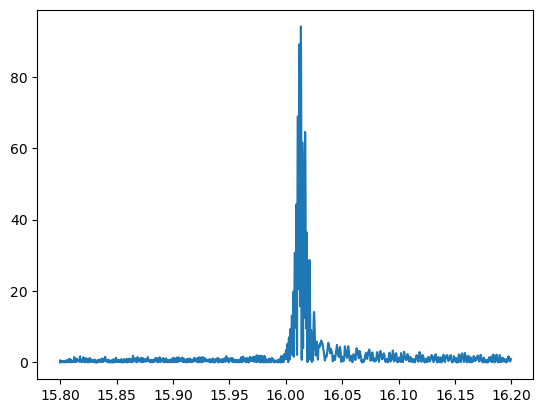

In [815]:
# Normalizzo il template
template_fft = dt * fft(strain_template)
template_fft_conjugate = template_fft.conjugate()

integrand_norm = np.divide(template_fft*template_fft_conjugate,(Pxx_noise_filtered_interp))

norm = sum(np.real(integrand_norm)) * df

template_fft_normalized = np.divide(template_fft,np.sqrt(norm))
template_fft_conjugate_normalized = np.divide(template_fft_conjugate,np.sqrt(norm))

# Faccio il Matched Filtering

data_fft = dt * fft(strain_data)

template_fft = dt * fft(strain_template)
template_fft_conjugate = template_fft.conjugate()

integrand = np.divide(data_fft*template_fft_conjugate_normalized,Pxx_noise_filtered_interp)

snr = ifft(integrand)/dt

plt.plot(time[int(15.8*fs):int(16.2*fs)], abs(snr[int(15.8*fs):int(16.2*fs)]))

# aggiungo un secondo perché ho tolto il primo secondo all'inizio
t_maxsnr = np.argmax(abs(snr[4096:-4096])) * dt + 1

print("t_signal =", t_maxsnr,"  snr = ", max(abs(snr[4096:-4096])))

Quindi abbiamo visto che il momento di picco dell'snr è a 16.014 secondi